In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
import warnings 
warnings.filterwarnings('ignore')
from tqdm import tqdm
import os
import time
from scipy.ndimage.interpolation import shift
#import scipy.stats
import FinanceDataReader as fdr
#import yfinance as yf
#import seaborn as sns
#from scipy import interpolate
from itertools import accumulate
from dateutil import relativedelta
from pykrx import stock
import datetime as dt
import seaborn as sns


In [2]:
def BSprice(PutCall, x, T, K, r, q, sigma):
    d1 =(1/(sigma*np.sqrt(T)))*(np.log(x/K) + (r - q + 0.5*sigma**2)*T)
    d2 = (1/(sigma*np.sqrt(T)))*(np.log(x/K) + (r - q - 0.5*sigma**2)*T)
    Nd1 = norm.cdf(d1)
    Nd2 = norm.cdf(d2)
    Nd1m = norm.cdf(-d1)
    Nd2m = norm.cdf(-d2)
    
    if PutCall == 'C':
        price1 = x*np.exp(-q*T)*Nd1 - K*np.exp(-r*T)*Nd2
        price2 = np.exp(-q*T)*Nd1
    elif PutCall =='P':
        price1 = K*np.exp(-r*T)*Nd2m - x*np.exp(-q*T)*Nd1m
        price2 = -np.exp(-q*T)*Nd1m
        
    return(price1,price2)           # returns array


In [3]:
def ch (name):
    cptype = name[7:8]
    maturity = name[9:15]
    strike = name[16:]

    return cptype+maturity+strike

def op_chain_df (cpflag, maturity, strike, data_list, s0=None):
    
    idx = (cpflag, maturity, strike)    
    df = data_list[idx].dropna()

    k = float(strike)

    if s0 is None:
        df['행사가격'] = [k for x in range(len(df))]
        return df

    else:
        df['행사가격'] = [k for x in range(len(df))]
        df['기초자산가'] = s0.loc[df.index]
        return df


def option_date_creator (week, date):
    '''마지막 만기 거래일이 나옴'''
    base_date = dt.datetime.strptime(date, '%Y-%m')
    option_date = base_date + relativedelta.relativedelta(weekday=3) + dt.timedelta(weeks=week)
    option_date = option_date.strftime('%Y-%m-%d')

    return option_date

# 데이터 불러오기

In [4]:
kospi200 = stock.get_index_ohlcv('20070801', '20221130', '1028')['종가']
file_path = os.getcwd() + '/Data/'

df_close   = pd.read_pickle(file_path+'Call_data_close.pkl')
df_base    = pd.read_pickle(file_path+'Call_data_base.pkl')
df_volume  = pd.read_pickle(file_path+'Call_data_volume.pkl')
df_imvol   = pd.read_pickle(file_path+'Call_data_imvol.pkl')
df_open    = pd.read_pickle(file_path+'Call_data_open.pkl')

df_close2   = pd.read_pickle(file_path+'Put_data_close.pkl')
df_base2    = pd.read_pickle(file_path+'Put_data_base.pkl')
df_volume2  = pd.read_pickle(file_path+'Put_data_volume.pkl')
df_imvol2   = pd.read_pickle(file_path+'Put_data_imvol.pkl')
df_open2    = pd.read_pickle(file_path+'Put_data_open.pkl')

data_list = [df_close, df_base, df_volume, df_imvol, df_open,\
             df_close2, df_base2, df_volume2, df_imvol2, df_open2]

test = []
ttt = ['종가', '기준가', '거래량', '내재변동성', '미결제약정', '종가', '기준가', '거래량', '내재변동성', '미결제약정']

for idx, dfdfdfdf in enumerate(data_list):

    tmp = dfdfdfdf.iloc[8:]
    tmp = tmp.set_axis(tmp.iloc[0], axis=1).drop(index=[8,9,10,11,12])

    tmp = tmp.rename(columns={tmp.columns[0] : 'Date'}).set_index('Date')
    tmp.index = pd.to_datetime(tmp.index)
    tmp.columns = [ch(x) for x in tmp.columns]

    k_list = [x[-5:] for x in tmp.columns]
    t_list = [x[1:-5] for x in tmp.columns]
    c_list = [x[0] for x in tmp.columns]
    f_list = [ttt[idx] for x in tmp.columns]
    ppp = pd.DataFrame(data=tmp.values, index=tmp.index, columns=[c_list, t_list, k_list, f_list])
    test.append(ppp)

df = pd.concat(test, axis=1)
df

C                                                          \
           200709                                                           
            165.0  167.5  170.0  172.5  175.0  177.5  180.0  182.5  185.0   
               종가     종가     종가     종가     종가     종가     종가     종가     종가   
Date                                                                        
2007-08-01   65.3  65.75   63.3   60.8  58.35   55.9  53.45     51   48.6   
2007-08-02   63.2   65.6   63.1  60.65   58.2  55.75   53.3   50.9  49.55   
2007-08-03  70.55  68.05     66   62.4  60.65   58.2  55.75  53.75  50.85   
2007-08-06   67.5  64.95   62.5     60   57.6   55.1   52.7  50.25  47.85   
2007-08-07     70  66.25  63.75   61.3  58.85  56.35   53.9  51.45     49   
...           ...    ...    ...    ...    ...    ...    ...    ...    ...   
2022-11-24    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2022-11-25    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2022-11-28    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2022-11-29    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2022-11-30    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   

                   ...      P                                                  \
                   ... 202211                                                   
            187.5  ...  452.5 455.0 457.5 460.0 462.5 465.0 467.5 470.0 472.5   
               종가  ...  미결제약정 미결제약정 미결제약정 미결제약정 미결제약정 미결제약정 미결제약정 미결제약정 미결제약정   
Date               ...                                                          
2007-08-01   46.2  ...    NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
2007-08-02  46.05  ...    NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
2007-08-03  48.95  ...    NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
2007-08-06   45.5  ...    NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
2007-08-07   46.6  ...    NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
...           ...  ...    ...   ...   ...   ...   ...   ...   ...   ...   ...   
2022-11-24    NaN  ...    NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
2022-11-25    NaN  ...    NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
2022-11-28    NaN  ...    NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
2022-11-29    NaN  ...    NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
2022-11-30    NaN  ...    NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   

                  
                  
           475.0  
           미결제약정  
Date              
2007-08-01   NaN  
2007-08-02   NaN  
2007-08-03   NaN  
2007-08-06   NaN  
2007-08-07   NaN  
...          ...  
2022-11-24   NaN  
2022-11-25   NaN  
2022-11-28   NaN  
2022-11-29   NaN  
2022-11-30   NaN  

[3789 rows x 84590 columns]

In [5]:
ticker_list = [ch(x) for x in df_close.iloc[8].values][1:]
maturity_date = list(pd.Series([str(x[1:7]) for x in ticker_list]).unique())

upper = []
lower = []
k_list = []

for date in maturity_date:
    buffer = []
    for tick in ticker_list:
        if tick[1:7] == date:
            buffer.append(tick[7:])
        else:
            pass
    
    k_list.append(buffer)

    upper.append(buffer[np.argmax(buffer)])
    lower.append(buffer[np.argmin(buffer)])
    

reg = pd.DataFrame(data=[upper, lower], columns=maturity_date).T.rename(columns={0:'Upper', 1:'Lower'}).astype(float)
reg
reg['last_trade_date'] = [option_date_creator(1, f'{x[:4]}-{x[4:]}') for x in reg.index]
reg['k_list'] = k_list
reg

,Upper,Lower,last_trade_date,k_list
200709,270.0,165.0,2007-09-13,"[165.0, 167.5, 170.0, 172.5, 175.0, 177.5, 180..."
200710,275.0,192.5,2007-10-11,"[192.5, 195.0, 197.5, 200.0, 202.5, 205.0, 207..."
200711,277.5,192.5,2007-11-08,"[192.5, 195.0, 197.5, 200.0, 202.5, 205.0, 207..."
200712,277.5,195.0,2007-12-13,"[195.0, 197.5, 200.0, 202.5, 205.0, 207.5, 210..."
200801,277.5,210.0,2008-01-10,"[210.0, 212.5, 215.0, 217.5, 220.0, 222.5, 225..."
...,...,...,...,...
202207,515.0,222.5,2022-07-14,"[222.5, 225.0, 227.5, 230.0, 232.5, 235.0, 237..."
202208,490.0,222.5,2022-08-11,"[222.5, 225.0, 227.5, 230.0, 232.5, 235.0, 237..."
202209,520.0,220.0,2022-09-08,"[220.0, 222.5, 225.0, 227.5, 230.0, 232.5, 235..."
202210,480.0,180.0,2022-10-13,"[180.0, 182.5, 185.0, 187.5, 190.0, 192.5, 195..."


In [6]:
def imp_dist(c_k_under,c_k,c_k_over,k_distance,tau,r):
    g=(np.exp(r*tau)*(c_k_under+c_k_over-2*c_k))/(k_distance**2)
    return(g)


In [7]:
kospi200_start=kospi200[(kospi200.index>="2007-12-03")&(kospi200.index<"2022-10-17")]
#Month_data=kospi200_start.index.strftime("%Y%m")


In [8]:
def new_next_exp(today):

    next_mon = today + relativedelta.relativedelta(months=1)
    nnext_mon = next_mon + relativedelta.relativedelta(months=1)

    if today.day < 15:
        result = next_mon
    else:
        result = nnext_mon
        
    return result.strftime("%Y%m")
    

In [9]:
ac= {}
ap= {}

for i in tqdm(kospi200_start.index):
    try:
        ac[i] = df.loc[i,("C", new_next_exp(i), slice(None),'종가')].dropna()
        ap[i] = df.loc[i,("P", new_next_exp(i), slice(None),'종가')].dropna()

    except:
        ac[i] = np.nan
        ap[i] = np.nan      

100%|██████████| 3673/3673 [00:45<00:00, 80.69it/s] 


In [10]:
# ac= {}
# ap= {}

# for i in tqdm(kospi200_start.index):

#         ac[i] = df.loc[i,("C", new_next_exp(i), slice(None),'종가')].dropna()
#         ap[i] = df.loc[i,("P", new_next_exp(i), slice(None),'종가')].dropna()



In [11]:
ac_k = {}
ap_k = {}

for i in tqdm(kospi200_start.index):
        tmp_c=[]
        tmp_p=[]

        for j in range(len(ac[i]-1)):

                try:
                        
                        tmp_c.append(np.float(ac[i].index[j][2]))
                        ac_k[i]=tmp_c
                        tmp_p.append(np.float(ap[i].index[j][2]))
                        ap_k[i]=tmp_p
                except:
                        pass


100%|██████████| 3673/3673 [00:02<00:00, 1539.50it/s]


In [12]:
ot_c={}
ot_p={}
otm_price={}
for i in tqdm(kospi200_start.index):
    

        ot_c[i]=list(np.array(ac_k[i])[np.array(ac_k[i])>kospi200_start[i]])
        otc = ac[i].copy()
        otc.index = ac[i].index.droplevel([0,1,3])
        otc.index = pd.Series(otc.index).apply(lambda x: float(x))
        ot_c[i]=otc[ot_c[i]]
        
    
        ot_p[i]=list(np.array(ap_k[i])[np.array(ap_k[i])<kospi200_start[i]])
        otp = ap[i].copy()
        otp.index = ap[i].index.droplevel([0,1,3])
        otp.index = pd.Series(otp.index).apply(lambda x: float(x))
        ot_p[i]=ot_p[i]=otp[ot_p[i]]

        otm_price[i]=pd.concat([ot_p[i],ot_c[i]])

        
        

        #otm_strike[i]=ot_p[i]+ot_c[i]

100%|██████████| 3673/3673 [00:02<00:00, 1597.32it/s]


100%|██████████| 3673/3673 [00:00<00:00, 5090.45it/s]


In [97]:
kospi200_start.index[2578]

Timestamp('2018-05-03 00:00:00')

100%|██████████| 3673/3673 [00:00<00:00, 6114.41it/s] 


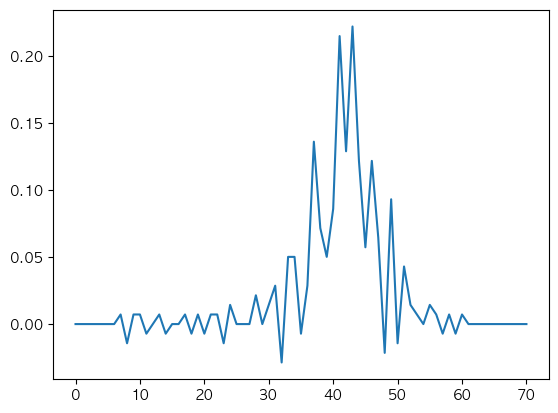

In [98]:
put_g={}
for i in tqdm(kospi200_start.index):
    tmp_p=[]
    option_point_p=ot_p[i]
    for j in range(len(option_point_p)-2):
        
        tmp_p.append(imp_dist(option_point_p.iloc[j],option_point_p.iloc[j+1],option_point_p.iloc[j+2],2.5,30,0.05))
    put_g[i]=tmp_p

call_g={}
for i in tqdm(kospi200_start.index):
    tmp_c=[]
    option_point_c=ot_c[i]
    for j in range(len(option_point_c)-2):
        
        tmp_c.append(imp_dist(option_point_c.iloc[j],option_point_c.iloc[j+1],option_point_c.iloc[j+2],2.5,30,0.05))
        
    call_g[i]=tmp_c

plt.plot(put_g[kospi200_start.index[2578]] + call_g[kospi200_start.index[2578]])

100%|██████████| 3673/3673 [00:00<00:00, 6062.17it/s] 


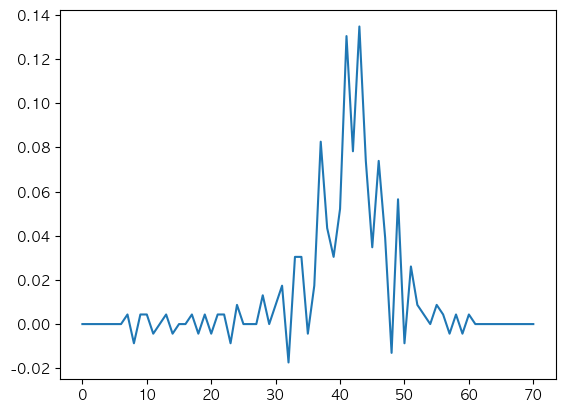

In [99]:
put_g={}
for i in tqdm(kospi200_start.index):
    tmp_p=[]
    option_point_p=ot_p[i]
    for j in range(len(option_point_p)-2):
        
        tmp_p.append(imp_dist(option_point_p.iloc[j],option_point_p.iloc[j+1],option_point_p.iloc[j+2],2.5,20,0.05))
    put_g[i]=tmp_p

call_g={}
for i in tqdm(kospi200_start.index):
    tmp_c=[]
    option_point_c=ot_c[i]
    for j in range(len(option_point_c)-2):
        
        tmp_c.append(imp_dist(option_point_c.iloc[j],option_point_c.iloc[j+1],option_point_c.iloc[j+2],2.5,20,0.05))
        
    call_g[i]=tmp_c

plt.plot(put_g[kospi200_start.index[2578]] + call_g[kospi200_start.index[2578]])

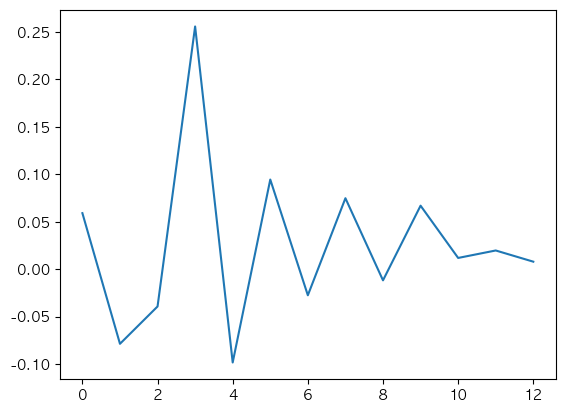

In [43]:
plt.plot(call_g[kospi200_start.index[0]])

In [17]:
put_call_g={}
for i in tqdm(kospi200_start.index):
    put_call_g[i]=put_g[i]+call_g[i]

100%|██████████| 3673/3673 [00:00<00:00, 713060.80it/s]


### G값

In [18]:
put_call_g

{Timestamp('2007-12-03 00:00:00'): [0.05509510968991589,
  0.019676824889255526,
  -0.011806094933553106,
  0.05903047466776657,
  0.059030474667766925,
  -0.03935364977851105,
  0.059030474667766925,
  -0.03935364977851105,
  0.13773777422478903,
  0.03935364977851175,
  -0.13773777422478972,
  0.059030474667766925,
  -0.0787072995570228,
  -0.03935364977851035,
  0.25579872356032285,
  -0.09838412444627798,
  0.09444875946842694,
  -0.027547554844957592,
  0.07477193457917142,
  -0.01180609493355328,
  0.06690120462346899,
  0.01180609493355328,
  0.019676824889255613,
  0.007870729955702158],
 Timestamp('2007-12-04 00:00:00'): [-0.023612189867106736,
  -0.011806094933553106,
  0.10231948942412901,
  0.011806094933553455,
  -0.08657802951272452,
  0.1180609493355335,
  -0.019676824889255876,
  0.03935364977851175,
  0.03935364977851105,
  0.03935364977851175,
  0.0787072995570221,
  0.03935364977851175,
  0.21644507378181183,
  -0.059030474667766925,
  0.09838412444627798,
  -0.01967

###  ac_k 와 ac_p는 같다

In [19]:
s=0                               ##  ac_k 와 ac_p는 같다
for i in kospi200_start.index:
    if len(ac_k[i])!=len(ap_k[i]):
        s=s+1
s

0

### strike price

In [20]:
g_strike_price={}
for i in kospi200_start.index:
    g_strike_price[i]=ac_k[i][:-4]
g_strike_price

{Timestamp('2007-12-03 00:00:00'): [210.0,
  212.5,
  215.0,
  217.5,
  220.0,
  222.5,
  225.0,
  227.5,
  230.0,
  232.5,
  235.0,
  237.5,
  240.0,
  242.5,
  245.0,
  247.5,
  250.0,
  252.5,
  255.0,
  257.5,
  260.0,
  262.5,
  265.0,
  267.5],
 Timestamp('2007-12-04 00:00:00'): [210.0,
  212.5,
  215.0,
  217.5,
  220.0,
  222.5,
  225.0,
  227.5,
  230.0,
  232.5,
  235.0,
  237.5,
  240.0,
  242.5,
  245.0,
  247.5,
  250.0,
  252.5,
  255.0,
  257.5,
  260.0,
  262.5,
  265.0,
  267.5],
 Timestamp('2007-12-05 00:00:00'): [210.0,
  212.5,
  215.0,
  217.5,
  220.0,
  222.5,
  225.0,
  227.5,
  230.0,
  232.5,
  235.0,
  237.5,
  240.0,
  242.5,
  245.0,
  247.5,
  250.0,
  252.5,
  255.0,
  257.5,
  260.0,
  262.5,
  265.0,
  267.5],
 Timestamp('2007-12-06 00:00:00'): [210.0,
  212.5,
  215.0,
  217.5,
  220.0,
  222.5,
  225.0,
  227.5,
  230.0,
  232.5,
  235.0,
  237.5,
  240.0,
  242.5,
  245.0,
  247.5,
  250.0,
  252.5,
  255.0,
  257.5,
  260.0,
  262.5,
  265.0,
  267.

## DataFrame만들기

In [21]:
col=kospi200_start.index
ind=np.zeros(1000)
dfs=pd.DataFrame(index=ind,columns=col)


In [22]:
dfs=pd.DataFrame(index=ind,columns=col)


In [23]:
for i in range(len(col)):
    input=put_call_g[kospi200_start.index[i]]
    dfs.iloc[:len(input),i]=input

In [24]:
implied_dist=dfs

In [25]:
coll=kospi200_start.index
indd=np.zeros(1000)

In [26]:
dff=pd.DataFrame(index=indd,columns=coll)

In [27]:
for i in range(len(coll)):
    input=g_strike_price[kospi200_start.index[i]]
    dff.iloc[:len(input),i]=input

In [28]:
strike=dff

In [29]:
# implied_dist.to_csv("implied_dist.csv")
# strike.to_csv("strike.csv")

In [30]:
------------------------

SyntaxError: invalid syntax (2206195933.py, line 1)

# SKEW 계산

In [ ]:
ac_IV= {}
ap_IV= {}

for i in tqdm(kospi200_start.index):
    try:
        ac_IV[i] = df.loc[i,("C", new_next_exp(i), slice(None),'내재변동성')].dropna()
        ap_IV[i] = df.loc[i,("P", new_next_exp(i), slice(None),'내재변동성')].dropna()

    except:
        ac_IV[i] = np.nan
        ap_IV[i] = np.nan      

100%|██████████| 3673/3673 [04:14<00:00, 14.40it/s]  


In [ ]:
ac_k_IV = {}
ap_k_IV = {}

for i in tqdm(kospi200_start.index):
        tmp_c=[]
        tmp_p=[]

        for j in range(len(ac_IV[i]-1)):

                try:
                        
                        tmp_c.append(np.float(ac_IV[i].index[j][2]))
                        ac_k_IV[i]=tmp_c
                        tmp_p.append(np.float(ap_IV[i].index[j][2]))
                        ap_k_IV[i]=tmp_p
                except:
                        pass


100%|██████████| 3673/3673 [00:07<00:00, 509.88it/s] 


In [ ]:
ot_c_IV={}
ot_p_IV={}
otm_price_IV={}
for i in tqdm(kospi200_start.index):
    

        ot_c_IV[i]=list(np.array(ac_k_IV[i])[np.array(ac_k_IV[i])>kospi200_start[i]])
        otc_IV = ac_IV[i].copy()
        otc_IV.index = ac_IV[i].index.droplevel([0,1,3])
        otc_IV.index = pd.Series(otc_IV.index).apply(lambda x: float(x))
        ot_c_IV[i]=otc_IV[ot_c_IV[i]]
        
    
        ot_p_IV[i]=list(np.array(ap_k_IV[i])[np.array(ap_k_IV[i])<kospi200_start[i]])
        otp_IV = ap_IV[i].copy()
        otp_IV.index = ap_IV[i].index.droplevel([0,1,3])
        otp_IV.index = pd.Series(otp_IV.index).apply(lambda x: float(x))
        ot_p_IV[i]=ot_p_IV[i]=otp_IV[ot_p_IV[i]]

        otm_price_IV[i]=pd.concat([ot_p_IV[i],ot_c_IV[i]])
        

        
        

        #otm_strike[i]=ot_p[i]+ot_c[i]

100%|██████████| 3673/3673 [00:06<00:00, 567.72it/s]


In [ ]:
def option_skew(otm_level):  #ex 0.95
    impvol={}

    for i in tqdm(kospi200_start.index):
        atm_impvol=otm_price_IV[i].iloc[np.argmin((otm_price_IV[i].index-kospi200_start[i])**2)]
        atm_k=otm_price_IV[i][otm_price_IV[i]==atm_impvol].index[0]
        otm_impvol=otm_price_IV[i].iloc[np.argmin((otm_price_IV[i].index-atm_k*otm_level)**2)]

        
        impvol[i]=otm_impvol-atm_impvol
    return(impvol)

            
                    

In [ ]:
def skew_df(otm_level):
    inddd=kospi200_start.index
    skew=pd.DataFrame(index=inddd)
    aaa=option_skew(otm_level)
    for i in kospi200_start.index:
        skew.loc[i,1]=aaa[i]
    return(skew)


In [ ]:
skew_df(0.95).to_csv("skew_95.csv")
skew_df(0.85).to_csv("skew_85.csv")
skew_df(0.75).to_csv("skew_75.csv")


100%|██████████| 3673/3673 [00:01<00:00, 2080.46it/s]
